**Import Library**

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

**Unzip File**

In [ ]:
!unzip -q skin-cancer-binary-classification-dataset.zip \
  && rm skin-cancer-binary-classification-dataset.zip

unzip:  cannot find or open skin-cancer-binary-classification-dataset.zip, skin-cancer-binary-classification-dataset.zip.zip or skin-cancer-binary-classification-dataset.zip.ZIP.


**Persiapan Dataset**

In [ ]:
original_base = "/content/skin-cancer-binary-classification-dataset/Skin_Data"
target_base = "/content/Data_Reorganized"

In [ ]:
if os.path.exists(target_base):
    shutil.rmtree(target_base)
os.makedirs(target_base)

# Buat folder baru untuk training dan testing
for split in ['Training', 'Testing']:
    for label in ['Cancer', 'Non_Cancer']:
        src_dir = os.path.join(original_base, label, split)
        dst_dir = os.path.join(target_base, split, label)
        os.makedirs(dst_dir, exist_ok=True)

        # Salin file dari folder asli ke folder target
        # Menggunakan shutil.copy2 untuk menjaga metadata file
        for filename in os.listdir(src_dir):
            src_file = os.path.join(src_dir, filename)
            dst_file = os.path.join(dst_dir, filename)
            shutil.copy2(src_file, dst_file)

print(f"Dataset berhasil diorganisir ulang di: {target_base}")
print(f"Jumlah gambar Training Cancer: {len(os.listdir(os.path.join(target_base, 'Training', 'Cancer')))}")
print(f"Jumlah gambar Training Non_Cancer: {len(os.listdir(os.path.join(target_base, 'Training', 'Non_Cancer')))}")
print(f"Jumlah gambar Testing Cancer: {len(os.listdir(os.path.join(target_base, 'Testing', 'Cancer')))}")
print(f"Jumlah gambar Testing Non_Cancer: {len(os.listdir(os.path.join(target_base, 'Testing', 'Non_Cancer')))}")


Dataset berhasil diorganisir ulang di: /content/Data_Reorganized
Jumlah gambar Training Cancer: 67
Jumlah gambar Training Non_Cancer: 67
Jumlah gambar Testing Cancer: 17
Jumlah gambar Testing Non_Cancer: 17


**Image Augmentation**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (150, 150)
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/Data_Reorganized/Training',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    '/content/Data_Reorganized/Testing',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 134 images belonging to 2 classes.
Found 34 images belonging to 2 classes.


**CNN**

In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.5621 - loss: 0.6912

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 553ms/step - accuracy: 0.5467 - loss: 0.6935 - val_accuracy: 0.7353 - val_loss: 0.6871
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.4518 - loss: 0.7078 - val_accuracy: 0.5000 - val_loss: 0.6940
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.5158 - loss: 0.6904 - val_accuracy: 0.5000 - val_loss: 0.6822
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.4915 - loss: 0.6983 - val_accuracy: 0.7941 - val_loss: 0.6767
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.5240 - loss: 0.6902 - val_accuracy: 0.5294 - val_loss: 0.6729
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.5597 - loss: 0.6652 - val_accuracy: 0.6765 - val_loss: 0.6657
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5969 - loss: 0.6671 - val_accuracy: 0.7647 - val_loss: 0.6565
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.5854 - loss: 0.6708 - val_accuracy: 0.5588 - val_loss: 0.

**Evaluasi**

In [ ]:
# Prediksi
pred_probs = model.predict(test_generator)
preds = (pred_probs > 0.5).astype("int32")
true = test_generator.classes


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step


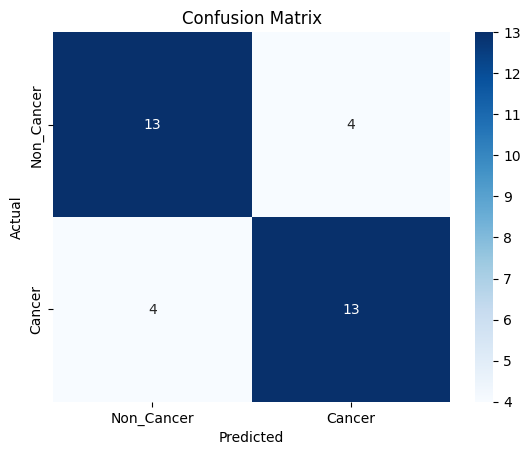

In [ ]:
# Confusion Matrix
cm = confusion_matrix(true, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non_Cancer', 'Cancer'], yticklabels=['Non_Cancer', 'Cancer'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Saving 1142-01.JPG to 1142-01.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/tmp/ipython-input-45-3788883681.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = int(predictions[0] > 0.5)  # <- FIX


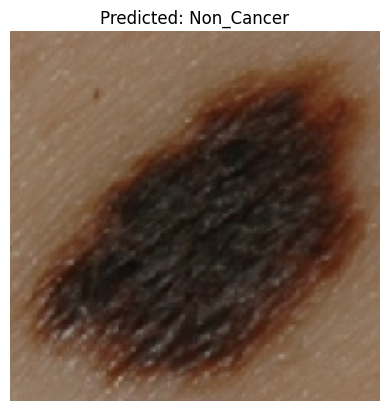

In [ ]:
from google.colab import files
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

uploaded = files.upload()

class_names = list(train_generator.class_indices.keys())

for fn in uploaded.keys():
    # Load dan preprocess gambar
    img_path = fn
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array /= 255.0

    # Prediksi
    predictions = model.predict(img_array)
    predicted_class = int(predictions[0] > 0.5)  # <- FIX

    # Tampilkan
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {class_names[predicted_class]}")
    plt.show()


**Save the Model**

In [ ]:
model.save('model_imk(final).h5')